In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.multioutput import MultiOutputRegressor
import joblib

In [10]:
data = pd.read_csv('global-data-on-sustainable-energy (1).csv')
pd.set_option('display.max_columns', None)
print("Dataset Head:\n", data.head())
print("\nDataset Info:\n", data.info())
print("\nDataset Description:\n", data.describe())

Dataset Head:
         Entity  Year  Access to electricity (% of population)  \
0  Afghanistan  2000                                 1.613591   
1  Afghanistan  2001                                 4.074574   
2  Afghanistan  2002                                 9.409158   
3  Afghanistan  2003                                14.738506   
4  Afghanistan  2004                                20.064968   

   Access to clean fuels for cooking  \
0                                6.2   
1                                7.2   
2                                8.2   
3                                9.5   
4                               10.9   

   Renewable-electricity-generating-capacity-per-capita  \
0                                               9.22      
1                                               8.86      
2                                               8.47      
3                                               8.09      
4                                               7.75      

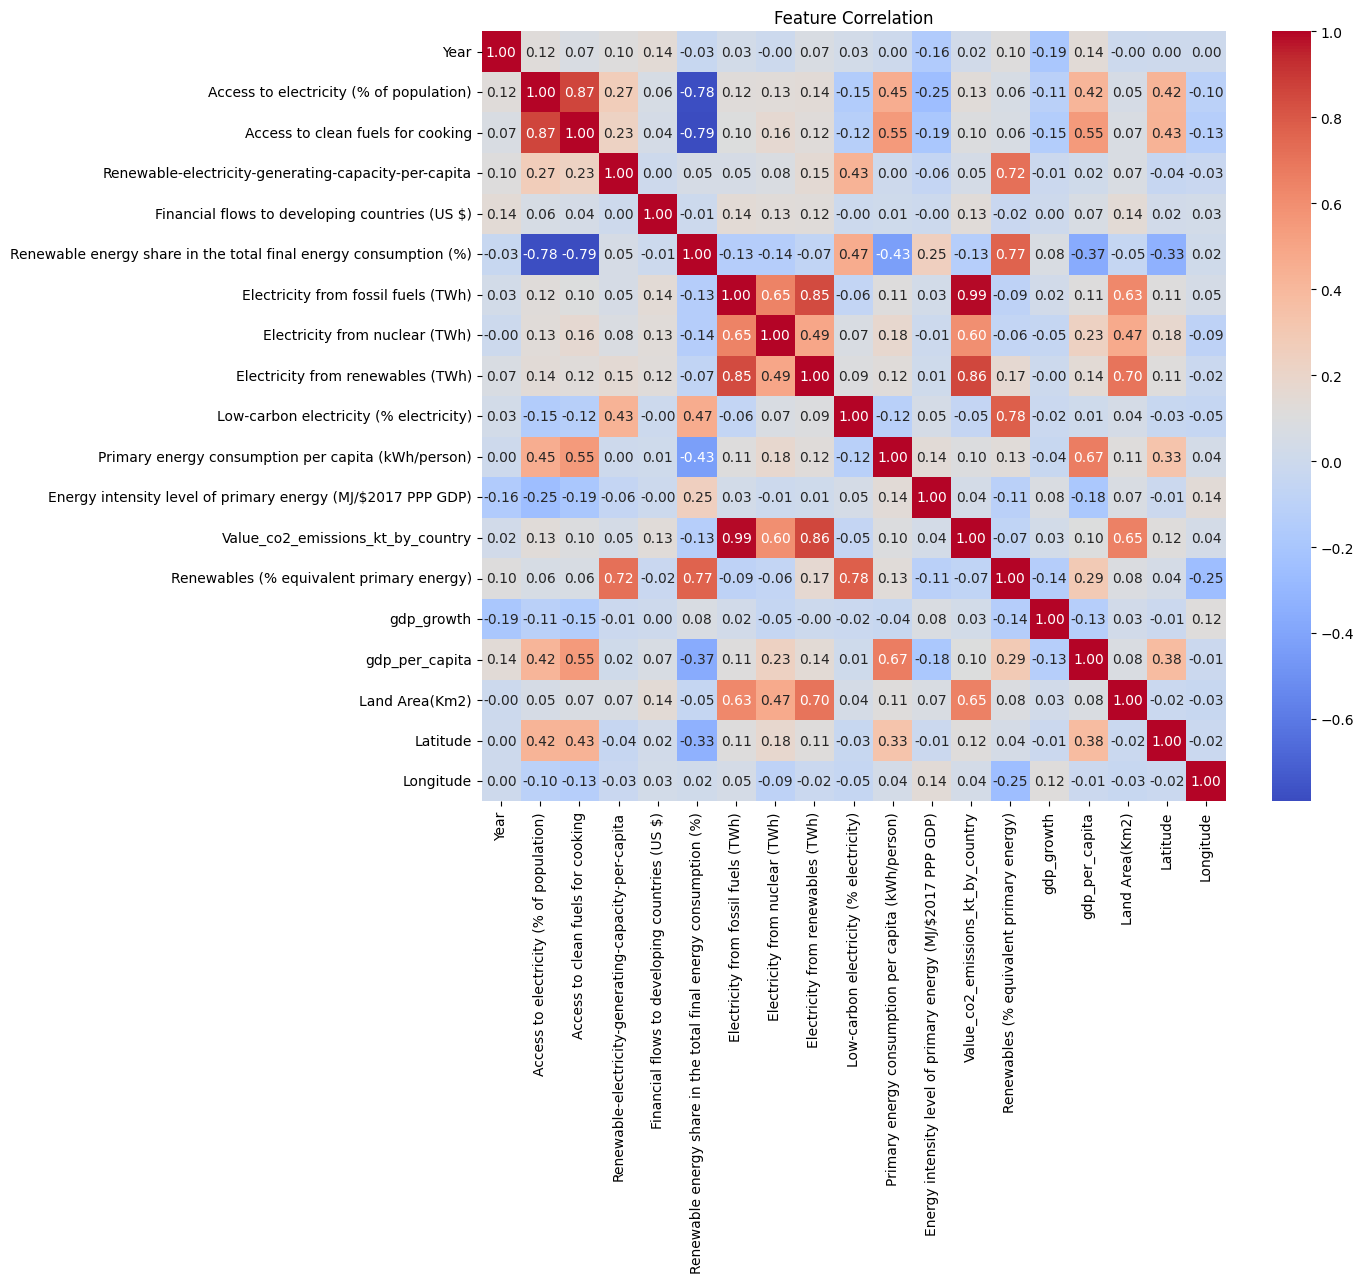

In [11]:
# Select only numeric columns for correlation
numeric_data = data.select_dtypes(include=np.number)

plt.figure(figsize=(12,10))
sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()


In [12]:
# Strip spaces from column names
data.columns = data.columns.str.strip()

# Identifier columns
id_columns = ['entity', 'Year']

# Drop identifiers
X = data.drop(columns=[col for col in id_columns if col in data.columns])

# Multi-output targets
target_columns = [
    'Value_co2_emissions_kt_by_country',
    'Renewable energy share in the total final energy consumption (%)',
    'Electricity from renewables (TWh)',
    'Primary energy consumption per capita (kWh/person)'
]

# Features = all numeric columns except targets
X_features = X.drop(columns=[col for col in target_columns if col in X.columns])
X_features = X_features.select_dtypes(include=np.number)  # select only numeric

# Targets
y = X[[col for col in target_columns if col in X.columns]]

# Fill missing values with mean (numeric only)
X_features = X_features.fillna(X_features.mean())
y = y.fillna(y.mean())

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

print("Preprocessing complete. Features and targets ready.")


Preprocessing complete. Features and targets ready.


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [14]:
models = {
    "Linear Regression": MultiOutputRegressor(LinearRegression()),
    "Ridge Regression": MultiOutputRegressor(Ridge(alpha=1.0)),
    "Lasso Regression": MultiOutputRegressor(Lasso(alpha=0.01)),
    "Random Forest": MultiOutputRegressor(RandomForestRegressor(n_estimators=200, random_state=42)),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42))
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Evaluation:")
    for i, col in enumerate(y.columns):
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
        print(f"{col} - MSE: {mse:.2f}, R2: {r2:.2f}")


Linear Regression Evaluation:
Value_co2_emissions_kt_by_country - MSE: 10817109906.66, R2: 0.96
Renewable energy share in the total final energy consumption (%) - MSE: 182.47, R2: 0.78
Electricity from renewables (TWh) - MSE: 1336.42, R2: 0.69
Primary energy consumption per capita (kWh/person) - MSE: 487714731.11, R2: 0.58

Ridge Regression Evaluation:
Value_co2_emissions_kt_by_country - MSE: 10827350744.17, R2: 0.96
Renewable energy share in the total final energy consumption (%) - MSE: 182.47, R2: 0.78
Electricity from renewables (TWh) - MSE: 1335.57, R2: 0.69
Primary energy consumption per capita (kWh/person) - MSE: 487667633.43, R2: 0.58

Lasso Regression Evaluation:
Value_co2_emissions_kt_by_country - MSE: 10817108644.49, R2: 0.96
Renewable energy share in the total final energy consumption (%) - MSE: 182.47, R2: 0.78
Electricity from renewables (TWh) - MSE: 1335.67, R2: 0.69
Primary energy consumption per capita (kWh/person) - MSE: 487714716.69, R2: 0.58

Random Forest Evaluatio

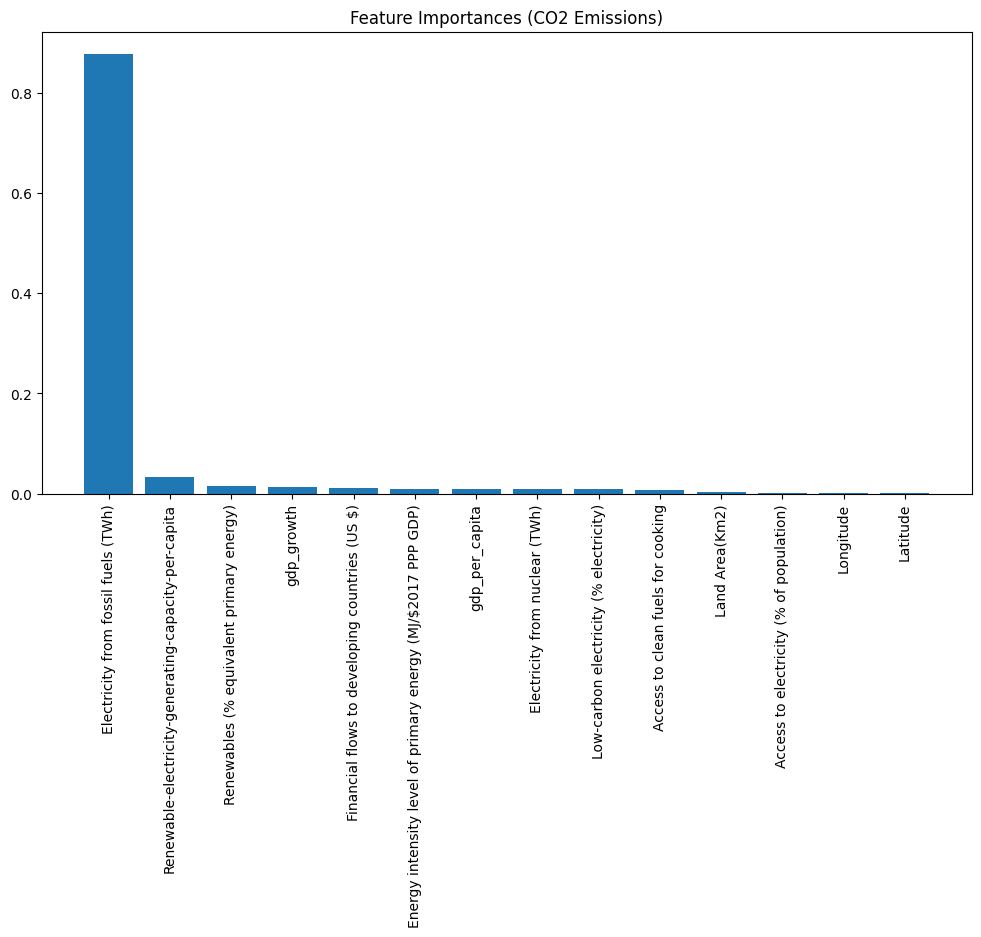

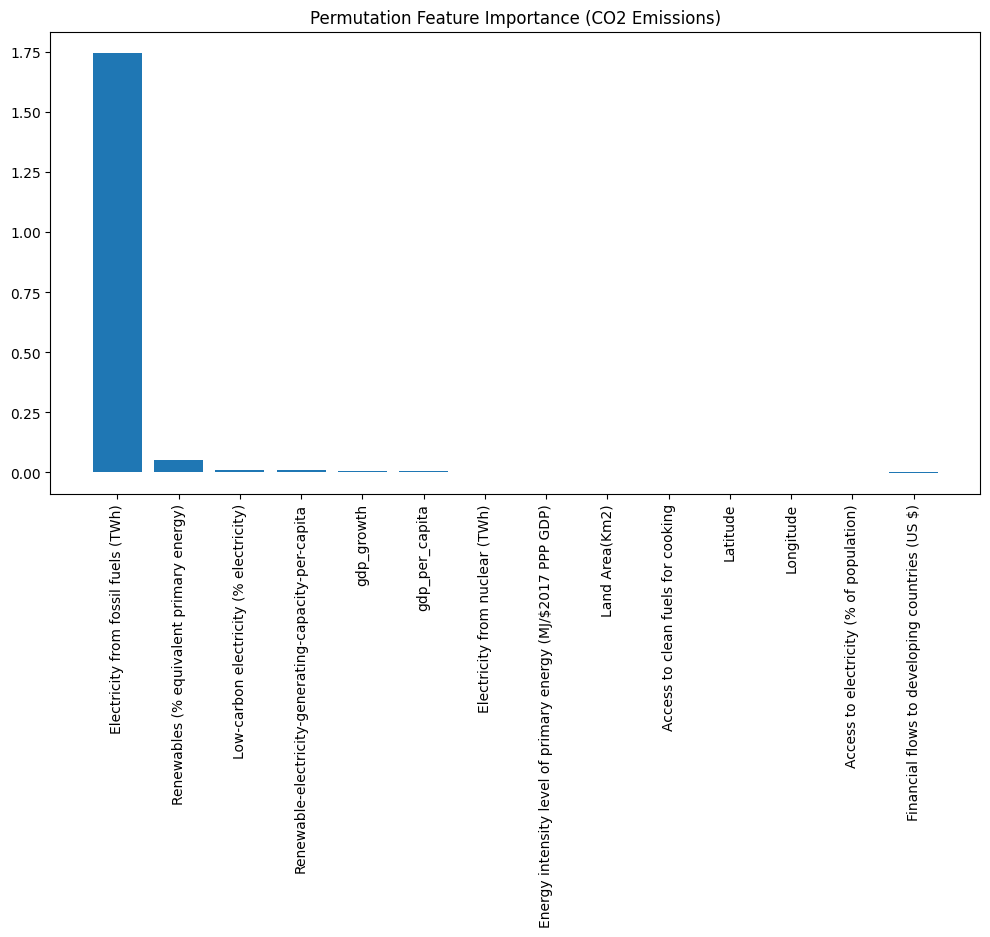

In [15]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train['Value_co2_emissions_kt_by_country'])

importances = rf_model.feature_importances_
features = X_features.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title("Feature Importances (CO2 Emissions)")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
plt.show()

perm_importance = permutation_importance(rf_model, X_test, y_test['Value_co2_emissions_kt_by_country'])
sorted_idx = perm_importance.importances_mean.argsort()[::-1]

plt.figure(figsize=(12,6))
plt.bar(range(len(features)), perm_importance.importances_mean[sorted_idx])
plt.xticks(range(len(features)), features[sorted_idx], rotation=90)
plt.title("Permutation Feature Importance (CO2 Emissions)")
plt.show()

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [100],
    'max_depth': [None],
    'min_samples_split': [2]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=2,
    n_jobs=-1,
    scoring='r2',
    verbose=2
)
grid_search.fit(X_train, y_train['Value_co2_emissions_kt_by_country'])

print("Best params (CO2 RF):", grid_search.best_params_)
print("Best R2 Score on Train:", grid_search.best_score_)


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best params (CO2 RF): {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best R2 Score on Train: 0.9026812641889981


In [22]:
best_model = grid_search.best_estimator_
joblib.dump(best_model, 'best_co2_model.pkl')
joblib.dump(models["Random Forest"], 'multi_output_energy_model.pkl')  # Save multi-output RF
joblib.dump(scaler, 'feature_scaler.pkl')
print("\nModels and scaler saved successfully!")


Models and scaler saved successfully!


In [23]:
from google.colab import files

files.download("best_co2_model.pkl")
files.download("multi_output_energy_model.pkl")
files.download("feature_scaler.pkl")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>